# U-Net Segmentation with COCO JSON Masks (Local, PyTorch)

This notebook trains a **U-Net** segmentation model where **masks are stored in a COCO JSON file** (e.g. Roboflow export),
not as separate PNGs.

Pipeline:

1. Setup & imports  
2. Load COCO JSON & build index  
3. Dataset class (image + mask from COCO) + Albumentations  
4. U-Net model  
5. Training & validation loop (Dice + BCEWithLogits)  
6. Visualize predictions


In [6]:
# If needed, install these once in your environment (NOT Colab-specific):
# !pip install torch torchvision albumentations opencv-python matplotlib pycocotools

import os
import json
from pathlib import Path
from datetime import datetime

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pycocotools import mask as mask_utils
import torch.nn.functional as F  # if not already imported



## CONFIG

In [ ]:
# Root directory containing images + COCO JSON
# Example structure:
#   tb_data/
#     images/
#       scene01_img01.jpg
#       ...
#     _annotations.coco.json

DATA_ROOT  = Path("data372")   # <-- change to your folder
IMAGES_DIR = DATA_ROOT / ""
COCO_JSON  = DATA_ROOT / "_annotations.coco.json"

# Training hyperparameters
IMAGE_SIZE  = 512
BATCH_SIZE  = 4
NUM_WORKERS = 0
NUM_EPOCHS  = 5
LR          = 1e-3

# Toggle for extra Albumentations-based augmentations
USE_ALBUMENTATIONS = False  # dataset already includes augmentations
CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# We’ll do **binary** segmentation: induration vs background
NUM_CLASSES = 1
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cpu


## COCO LOADING

In [8]:
with open(COCO_JSON, "r") as f:
    coco = json.load(f)

# Build image dict: id -> info
images_by_id = {img["id"]: img for img in coco["images"]}

# Build annotation lists grouped by image_id
anns_by_img = {img_id: [] for img_id in images_by_id.keys()}
for ann in coco["annotations"]:
    anns_by_img[ann["image_id"]].append(ann)

# Category mapping id -> name
cat_id_to_name = {c["id"]: c["name"] for c in coco.get("categories", [])}

print(f"Total images in COCO: {len(images_by_id)}")
print(f"Total annotations:    {len(coco['annotations'])}")
print("Categories:", cat_id_to_name)


Total images in COCO: 372
Total annotations:    744
Categories: {0: 'objects', 1: 'induration', 2: 'sticker'}


In [9]:
def decode_single_mask(ann, img_h, img_w):
    """
    Decode ONE annotation's segmentation into a binary mask (H, W), bool.

    Supports:
      - RLE dict: {"size": [h,w], "counts": ...}
      - Polygon list: [[x1,y1,...], [...], ...]
    """
    seg = ann["segmentation"]

    # --- RLE case ---
    if isinstance(seg, dict) and "counts" in seg:
        rle = seg
        # Handle uncompressed RLE (counts as list)
        if isinstance(rle["counts"], list):
            rle = mask_utils.frPyObjects(rle, rle["size"][0], rle["size"][1])

        m = mask_utils.decode(rle)  # (H, W) or (H, W, 1)
        if m.ndim == 3:
            m = m[:, :, 0]

        # If needed, resize to image size (should usually match already)
        if m.shape[0] != img_h or m.shape[1] != img_w:
            m = cv2.resize(m.astype(np.uint8),
                           (img_w, img_h),
                           interpolation=cv2.INTER_NEAREST)
        return m.astype(bool)

    # --- Polygon(s) case ---
    elif isinstance(seg, list):
        m = np.zeros((img_h, img_w), dtype=np.uint8)
        for poly in seg:
            pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
            pts = pts.reshape((-1, 1, 2)).astype(np.int32)
            cv2.fillPoly(m, [pts], 1)
        return m.astype(bool)

    else:
        raise ValueError(f"Unsupported segmentation type: {type(seg)}")


def build_induration_mask(img_id, img_h, img_w):
    """
    Build a **binary mask** (H, W) for the 'induration' class only
    for a given image_id by unioning all its induration annotations.
    """
    anns = anns_by_img.get(img_id, [])
    mask = np.zeros((img_h, img_w), dtype=bool)

    for ann in anns:
        cat_id = ann["category_id"]
        cat_name = cat_id_to_name.get(cat_id, "").lower()

        # Only keep induration annotations
        if "induration" not in cat_name:
            continue

        m = decode_single_mask(ann, img_h, img_w)  # bool
        mask |= m

    return mask.astype("float32")  # 0.0/1.0


In [10]:
class COCOSegmentationDataset(Dataset):
    """
    Dataset that reads images + masks from COCO JSON.

    Returns:
      image: Tensor (3, H, W), float
      mask:  Tensor (1, H, W), float in {0, 1}
    """
    def __init__(self, image_ids, images_by_id, images_dir, transform=None):
        self.image_ids = list(image_ids)
        self.images_by_id = images_by_id
        self.images_dir = Path(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        info = self.images_by_id[img_id]
        file_name = info["file_name"]
        img_path = str(self.images_dir / file_name)

        # Load image
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        # Build binary induration mask from COCO
        mask = build_induration_mask(img_id, h, w)  # (H, W), float32 0/1

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask  = augmented["mask"]

        # (H, W) -> (1, H, W)
        if mask.ndim == 2:
            mask = mask[None, ...]

        return image, mask


In [11]:
def make_transforms(image_size=IMAGE_SIZE, use_augmentations=USE_ALBUMENTATIONS):
    """
    Build train/val Albumentations pipelines.

    - If use_augmentations=False:
        only resize/pad + normalize + ToTensorV2 (no random aug).
    - If use_augmentations=True:
        add extra random geometric / color augmentations to the train pipeline.
    """

    # Common deterministic transforms (always applied)
    base_resize_pad = [
        A.LongestMaxSize(max_size=image_size, p=1.0),
        A.PadIfNeeded(
            min_height=image_size,
            min_width=image_size,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            mask_value=0,
            p=1.0,
        ),
    ]

    base_norm_to_tensor = [
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]

    if not use_augmentations:
        # *** No extra data aug: just resize + pad + normalize ***
        train_transform = A.Compose(base_resize_pad + base_norm_to_tensor)
    else:
        # *** Extra random augmentations for training ***
        extra_train_aug = [
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=cv2.BORDER_REFLECT_101,
                value=0,
                mask_value=0,
                p=0.9,
            ),
            A.HorizontalFlip(p=0.5),
            A.OneOf(
                [
                    A.RandomBrightnessContrast(
                        brightness_limit=0.2,
                        contrast_limit=0.2,
                        p=1.0,
                    ),
                    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
                ],
                p=0.5,
            ),
        ]

        train_transform = A.Compose(
            base_resize_pad + extra_train_aug + base_norm_to_tensor
        )

    # Validation: always deterministic, no random aug
    val_transform = A.Compose(base_resize_pad + base_norm_to_tensor)

    return train_transform, val_transform


def make_dataloaders(val_split=0.2):
    all_img_ids = list(images_by_id.keys())
    all_img_ids.sort()  # deterministic order
    n_total = len(all_img_ids)
    n_val   = max(1, int(n_total * val_split))

    train_ids = all_img_ids[:-n_val]
    val_ids   = all_img_ids[-n_val:]

    train_tf, val_tf = make_transforms(use_augmentations=USE_ALBUMENTATIONS)

    train_ds = COCOSegmentationDataset(train_ids, images_by_id, IMAGES_DIR, transform=train_tf)
    val_ds   = COCOSegmentationDataset(val_ids,   images_by_id, IMAGES_DIR, transform=val_tf)

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    print(f"Train images: {len(train_ds)}, Val images: {len(val_ds)}")
    return train_loader, val_loader


In [12]:
def save_checkpoint(model, optimizer=None, epoch=None, val_metric=None, prefix="unet"):
    """
    Save a timestamped checkpoint so files are never overwritten.
    Filename example:
      checkpoints/unet_epoch005_miou0.812_20251209_191530.pth
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Build a descriptive filename
    parts = [prefix]
    if epoch is not None:
        parts.append(f"epoch{epoch:03d}")
    if val_metric is not None:
        parts.append(f"miou{val_metric:.3f}")
    parts.append(timestamp)

    filename = "_".join(parts) + ".pth"
    ckpt_path = CHECKPOINT_DIR / filename

    state = {"model_state": model.state_dict()}
    if optimizer is not None:
        state["optimizer_state"] = optimizer.state_dict()
    if epoch is not None:
        state["epoch"] = epoch
    if val_metric is not None:
        state["val_metric"] = val_metric

    torch.save(state, ckpt_path)
    print(f"Saved checkpoint to: {ckpt_path}")


## U-NET

In [13]:
class DoubleConv(nn.Module):
    """(Conv2d => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """Downscale with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """Upscale then DoubleConv with skip connection"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, 2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad if needed (due to odd size)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc   = DoubleConv(n_channels, 64)
        self.down1 = Down(64,   128)
        self.down2 = Down(128,  256)
        self.down3 = Down(256,  512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512,  1024 // factor)
        self.up1   = Up(1024,  512 // factor, bilinear)
        self.up2   = Up(512,   256 // factor, bilinear)
        self.up3   = Up(256,   128 // factor, bilinear)
        self.up4   = Up(128,   64, bilinear)
        self.outc  = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x  = self.up1(x5, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)
        logits = self.outc(x)
        return logits


## TRAINING AND EVALUATION

In [14]:
def dice_coefficient(preds, targets, eps=1e-6):
    """
    Dice for binary segmentation.
    preds: logits (B,1,H,W)
    targets: masks (B,1,H,W), 0/1
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean().item()


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)

            dice = dice_coefficient(outputs, masks)
            running_dice += dice * images.size(0)

    val_loss = running_loss / len(loader.dataset)
    val_dice = running_dice / len(loader.dataset)
    return val_loss, val_dice


In [15]:
train_loader, val_loader = make_dataloaders(val_split=0.2)

model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

best_val_dice = 0.0
save_path = "unet_coco_best.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_dice = validate(model, val_loader, criterion, DEVICE)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Dice: {val_dice:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            val_metric=val_dice,
            prefix="unet_best"
        )


Train images: 298, Val images: 74


/var/folders/vd/z033x6cd5pv4gp1jt750qvgr0000gn/T/ipykernel_22914/2805966710.py:14: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
  File "/opt/an

RuntimeError: DataLoader worker (pid(s) 23883, 23884) exited unexpectedly

Loaded best model from unet_coco_best.pth


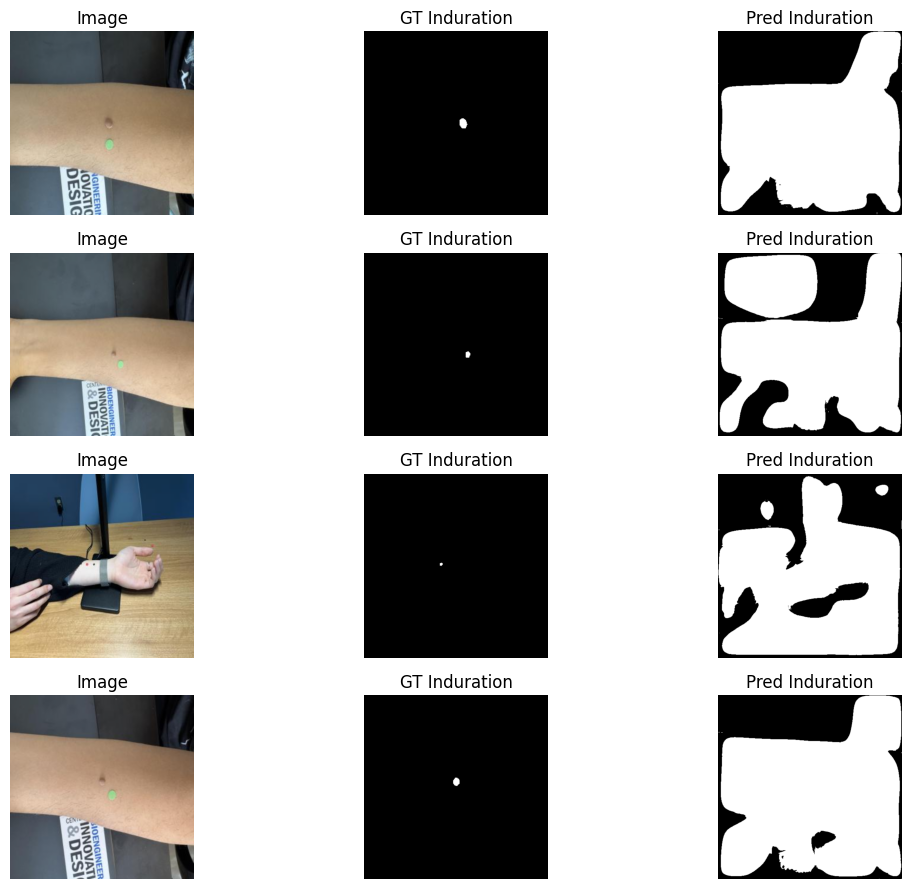

In [ ]:
# Load best model (optional)
if os.path.exists("unet_coco_best.pth"):
    model.load_state_dict(torch.load("unet_coco_best.pth", map_location=DEVICE))
    model.eval()
    print("Loaded best model from unet_coco_best.pth")

# Take a batch from validation
model.eval()
images, masks = next(iter(val_loader))
images = images.to(DEVICE)
masks  = masks.to(DEVICE)

with torch.no_grad():
    logits = model(images)
    probs  = torch.sigmoid(logits)
    preds  = (probs > 0.5).float()

images = images.cpu().numpy()
masks  = masks.cpu().numpy()
preds  = preds.cpu().numpy()

# Denormalize images for display
mean = np.array([0.485, 0.456, 0.406])[:, None, None]
std  = np.array([0.229, 0.224, 0.225])[:, None, None]

num_show = min(4, images.shape[0])
plt.figure(figsize=(12, 9))

for i in range(num_show):
    img = images[i]
    img = (img * std + mean).transpose(1, 2, 0)
    img = np.clip(img, 0, 1)

    mask_gt   = masks[i, 0]
    mask_pred = preds[i, 0]

    plt.subplot(num_show, 3, 3*i + 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(num_show, 3, 3*i + 2)
    plt.imshow(mask_gt, cmap="gray")
    plt.title("GT Induration")
    plt.axis("off")

    plt.subplot(num_show, 3, 3*i + 3)
    plt.imshow(mask_pred, cmap="gray")
    plt.title("Pred Induration")
    plt.axis("off")

plt.tight_layout()
plt.show()
